# Problem 2

In [50]:
# Widget to manipulate plots in Jupyter notebooks
%matplotlib widget 

import matplotlib.pyplot as plt # For general plotting

import numpy as np

from scipy.stats import multivariate_normal # MVN not univariate

np.set_printoptions(suppress=True)

# Set seed to generate reproducible "pseudo-randomness" (handles scipy's "randomness" too)
np.random.seed(7)

plt.rc('font', size=22)          # controls default text sizes
plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=18)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=14)    # fontsize of the tick labels
plt.rc('ytick', labelsize=14)    # fontsize of the tick labels
plt.rc('legend', fontsize=16)    # legend fontsize
plt.rc('figure', titlesize=22)   # fontsize of the figure title

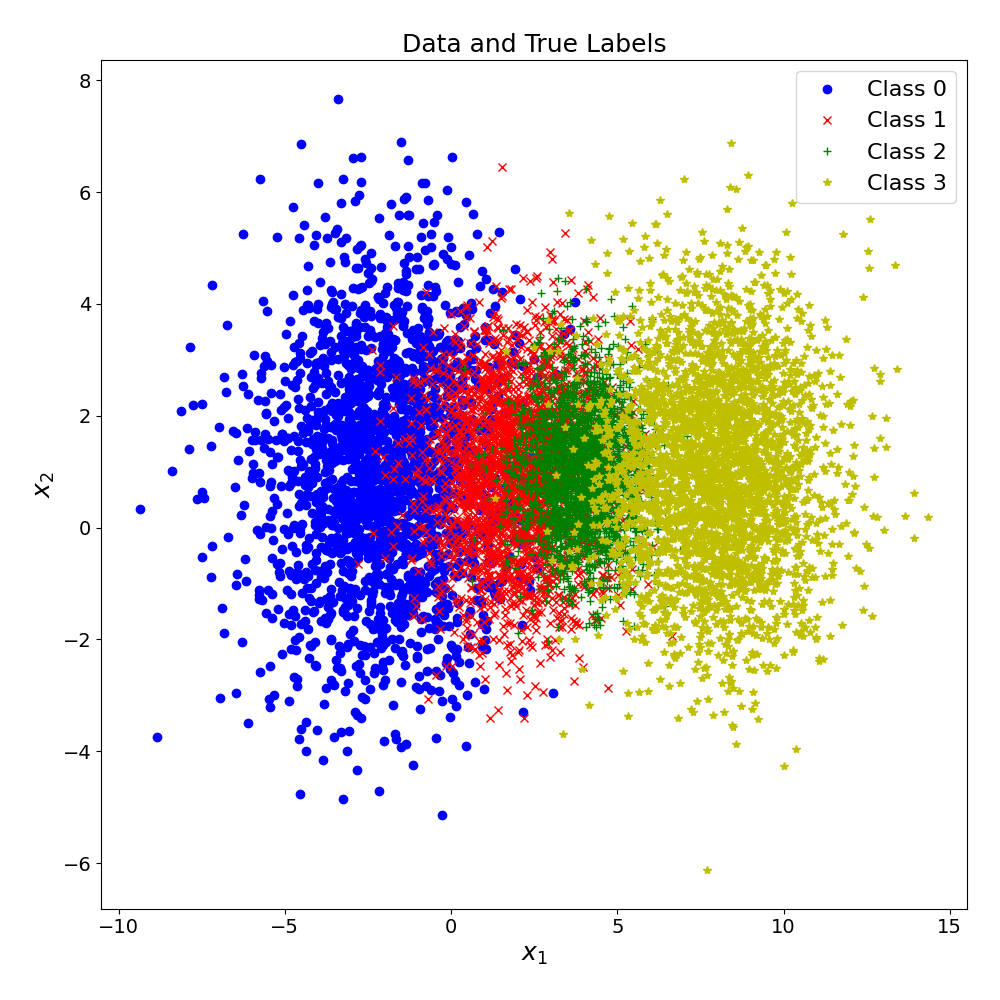

In [51]:
# Number of samples to draw from each distribution
N = 10000

# Likelihood of each distribution to be selected AND class priors!!!
priors = np.array([0.2, 0.25, 0.25, 0.3])  
# Determine number of classes/mixture components
C = len(priors)
mu = np.array([[-2, 1],
               [2, 1],
               [4, 1],
               [8, 1]])  # Gaussian distributions means
Sigma = np.array([[[4, 0],
                   [0, 4]],
                  [[2, 0],
                   [0, 2]],
                  [[1, 0],
                   [0, 1]],
                  [[3, 0],
                   [0, 3]]])  # Gaussian distributions covariance matrices

# Determine dimensionality from mixture PDF parameters
n = mu.shape[1]
# Output samples and labels
X = np.zeros([N, n])
y = np.zeros(N)

# Decide randomly which samples will come from each component
u = np.random.rand(N)
thresholds = np.cumsum(priors)

for c in range(C):
    c_ind = np.argwhere(u <= thresholds[c])[:, 0]  # Get randomly sampled indices for this component
    c_N = len(c_ind)  # No. of samples in this component
    y[c_ind] = c * np.ones(c_N)
    u[c_ind] = 1.1 * np.ones(c_N)  # Multiply by 1.1 to fail <= thresholds and thus not reuse samples
    X[c_ind, :] =  multivariate_normal.rvs(mu[c], Sigma[c], c_N)

# Plot the original data and their true labels
plt.figure(figsize=(10, 10))
plt.plot(X[y==0, 0], X[y==0, 1], 'bo', label="Class 0")
plt.plot(X[y==1, 0], X[y==1, 1], 'rx', label="Class 1");
plt.plot(X[y==2, 0], X[y==2, 1], 'g+', label="Class 2");
plt.plot(X[y==3, 0], X[y==3, 1], 'y*', label="Class 3");
plt.legend()
plt.xlabel(r"$x_1$")
plt.ylabel(r"$x_2$")
plt.title("Data and True Labels")
plt.tight_layout()
plt.show()

In [52]:
Y = np.array(range(C))  # 0-(C-1)

In [53]:
# We are going to use a 0-1 loss matrix for this problem
Lambda = np.ones((C, C)) - np.identity(C)
print(Lambda)

[[0. 1. 1. 1.]
 [1. 0. 1. 1.]
 [1. 1. 0. 1.]
 [1. 1. 1. 0.]]


In [54]:
# Calculate class-conditional likelihoods p(x|Y=j) for each label of the N observations
class_cond_likelihoods = np.array([multivariate_normal.pdf(X, mu[j], Sigma[j]) for j in Y])
class_priors = np.diag(priors)
print(class_cond_likelihoods.shape)
print(class_priors.shape)
class_posteriors = class_priors.dot(class_cond_likelihoods)
print(class_posteriors)

(4, 10000)
(4, 4)
[[0.00595091 0.00000004 0.00144096 ... 0.00000146 0.00044834 0.00602246]
 [0.001043   0.00000333 0.01701198 ... 0.00019723 0.01696647 0.00011716]
 [0.00000003 0.00001643 0.00188082 ... 0.00283892 0.0192727  0.        ]
 [0.00000001 0.01302687 0.00001698 ... 0.00976611 0.00017459 0.        ]]


In [55]:
# We want to create the risk matrix of size 4 x N 
cond_risk = Lambda.dot(class_posteriors)
print(cond_risk)

[[0.00104304 0.01304663 0.01890978 ... 0.01280225 0.03641375 0.00011716]
 [0.00595095 0.01304334 0.00333875 ... 0.01260649 0.01989562 0.00602246]
 [0.00699393 0.01303025 0.01846991 ... 0.0099648  0.0175894  0.00613963]
 [0.00699394 0.0000198  0.02033376 ... 0.00303761 0.03668751 0.00613963]]


In [56]:
# Get the decision for each column in risk_mat
decisions = np.argmin(cond_risk, axis=0)
print(decisions.shape)

(10000,)


Confusion matrix:
[[0.85524372 0.06092767 0.         0.        ]
 [0.1427868  0.69693396 0.12887237 0.00599201]
 [0.00196947 0.23624214 0.82940933 0.08255659]
 [0.         0.00589623 0.0417183  0.9114514 ]]
Minimum Probability of Error:
0.1744


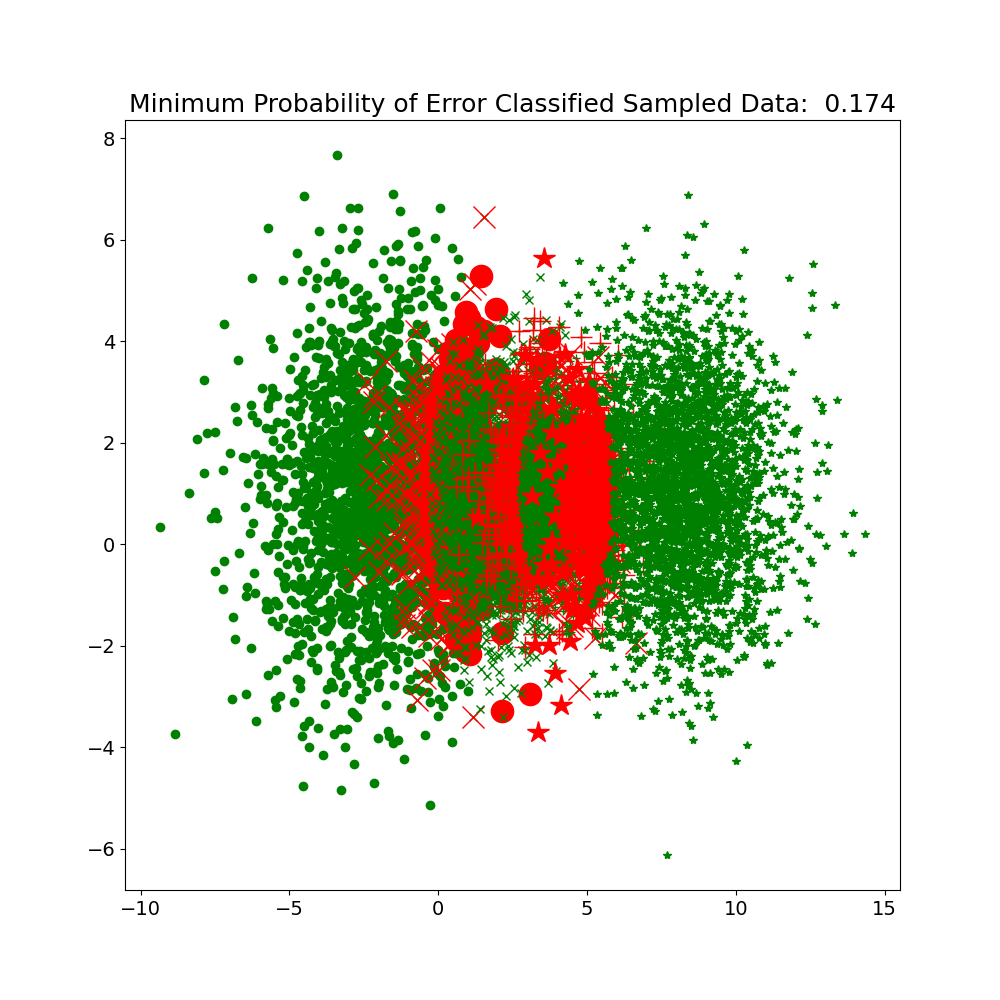

In [57]:
# Plot for decisions vs true labels
fig = plt.figure(figsize=(10, 10))
marker_shapes = 'ox+*.' # Accomodates up to C=5
marker_colors = 'brgy'

# Get sample class counts
sample_class_counts = np.array([sum(y == j) for j in Y])

# Confusion matrix
conf_mat = np.zeros((C, C))
for i in Y: # Each decision option
    for j in Y: # Each class label
        ind_ij = np.argwhere((decisions==i) & (y==j))
        conf_mat[i, j] = len(ind_ij)/sample_class_counts[j] # Average over class sample count

        # True label = Marker shape; Decision = Marker Color
        marker = marker_shapes[j] + 'g'
        plt.plot(X[ind_ij, 0], X[ind_ij, 1], marker)

        if i != j:
            marker = marker_shapes[j] + 'r'
            plt.plot(X[ind_ij, 0], X[ind_ij, 1], marker, markersize=16)
            
print("Confusion matrix:")
print(conf_mat)

print("Minimum Probability of Error:")
prob_error = 1 - np.diag(conf_mat).dot(sample_class_counts / N)
print(prob_error)

plt.title("Minimum Probability of Error Classified Sampled Data:  {:.3f}".format(prob_error))
plt.show()

## Part B

In [58]:
Lambda = np.array([[0, 1, 2, 3],
          [1, 0, 1, 2],
          [2, 1, 0, 1],
          [3, 2, 1, 0]])
print(Lambda)

[[0 1 2 3]
 [1 0 1 2]
 [2 1 0 1]
 [3 2 1 0]]


In [59]:
# We want to create the risk matrix of size 4 x N 
cond_risk = Lambda.dot(class_posteriors)
print(cond_risk)

[[0.00104308 0.0391168  0.02082455 ... 0.03517338 0.05603562 0.00011716]
 [0.00595096 0.02607021 0.00335573 ... 0.02237259 0.02007021 0.00602246]
 [0.01294484 0.01303029 0.01991087 ... 0.00996626 0.01803774 0.01216209]
 [0.01993878 0.00002322 0.04022765 ... 0.00323776 0.05455066 0.01830171]]


In [60]:
# Get the decision for each column in risk_mat
decisions = np.argmin(cond_risk, axis=0)
print(decisions.shape)

(10000,)


Confusion matrix:
[[0.85524372 0.06092767 0.         0.        ]
 [0.1427868  0.6961478  0.125981   0.00532623]
 [0.00196947 0.23781447 0.83560512 0.08821571]
 [0.         0.00511006 0.03841388 0.90645806]]
Minimum Probability of Error:
0.17459999999999998


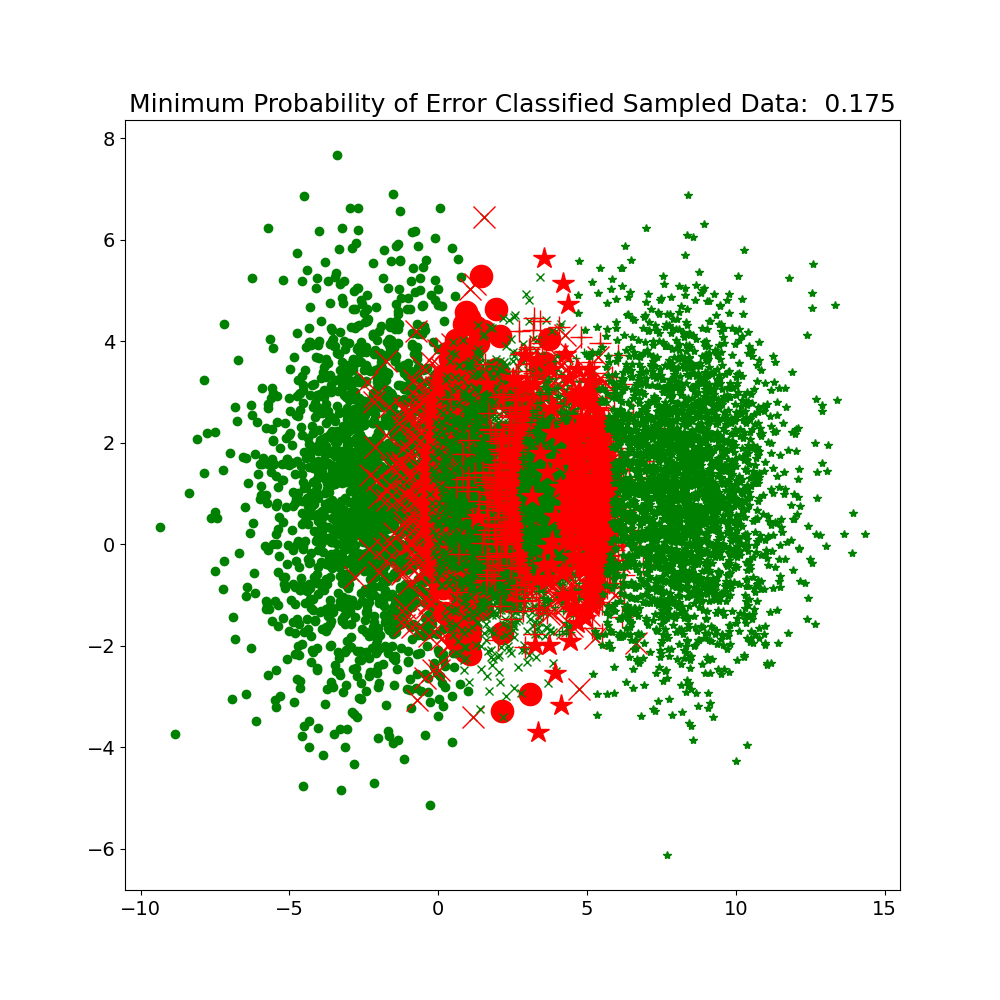

In [61]:
# Plot for decisions vs true labels
fig = plt.figure(figsize=(10, 10))
marker_shapes = 'ox+*.' # Accomodates up to C=5
marker_colors = 'brgy'

# Get sample class counts
sample_class_counts = np.array([sum(y == j) for j in Y])

# Confusion matrix
conf_mat = np.zeros((C, C))
for i in Y: # Each decision option
    for j in Y: # Each class label
        ind_ij = np.argwhere((decisions==i) & (y==j))
        conf_mat[i, j] = len(ind_ij)/sample_class_counts[j] # Average over class sample count

        # True label = Marker shape; Decision = Marker Color
        marker = marker_shapes[j] + 'g'
        plt.plot(X[ind_ij, 0], X[ind_ij, 1], marker)

        if i != j:
            marker = marker_shapes[j] + 'r'
            plt.plot(X[ind_ij, 0], X[ind_ij, 1], marker, markersize=16)
            
print("Confusion matrix:")
print(conf_mat)

print("Minimum Probability of Error:")
prob_error = 1 - np.diag(conf_mat).dot(sample_class_counts / N)
print(prob_error)

plt.title("Minimum Probability of Error Classified Sampled Data:  {:.3f}".format(prob_error))
plt.show()